In [1]:
import wandb
from datetime import datetime

In [2]:
mask_model_ver = 132508
lr = 5e-4
batch_size = 32
wd = 1e-5
IMAGE_SIZE = 512
backbone='efficientdetv2_ds'
vertical_type = "axial"
train_portion = 0.5
milestones = [10,20,30,40]
model_name = "effdet"
epochs =50

checkpoint = 'axial_detection_effdet_162305_last_99.pth'

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="YOLOR", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : IMAGE_SIZE,
})
wandb.run.name = f'axial_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'axial_detection_effdet_104709'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from effdet import create_model
from effdet import DetBenchPredict
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

import json
# from sklearn.model_selection import GroupKFold

%load_ext autoreload
%autoreload 2

# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95_croped_132508')
MASK_DIR = os.path.join(DATA_DIR, f'segmentation_axial_results_{mask_model_ver}')

BBOX_PATH = os.path.join(DATA_DIR, 'lm_labels/project-6-at-2022-10-25-00-32-79556e3e.json')


In [6]:
with open(BBOX_PATH) as json_file:
    bbox_data = json.load(json_file)
    print(len(bbox_data))

7321


In [7]:
bbox_df = pd.DataFrame()
for data in tqdm(bbox_data):
    image = data['data']['image']
    UID = image.split('/')[-2]
    Slice = image.split('/')[-1].replace('.jpeg','')
    
    if len(data['annotations'][0]['result']) == 0:
        print(f'none result {UID}')
        continue
    bbox = data['annotations'][0]['result'][0]['value']
    
    # coord = [bbox['x'], bbox['y'], bbox['width'], bbox['height']]
    
    new_s = pd.Series(data={
        'UID' : UID,
        'axial_index' : Slice,
        'x' : bbox['x'] * 5.12,
        'y' : bbox['y'] * 5.12,
        'width' : bbox['width'] * 5.12,
        'height' : bbox['height'] * 5.12
    })
    
    bbox_df = pd.concat((bbox_df, new_s.to_frame().T), axis=0)

bbox_df = bbox_df.sort_values(['UID','axial_index']).reset_index(drop=True)
print(len(bbox_df.UID.unique()))
print(len(bbox_df))
bbox_df.tail()

  2%|▏         | 172/7321 [00:00<00:04, 1718.42it/s]

none result 1.2.826.0.1.3680043.13063
none result 1.2.826.0.1.3680043.13063
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037


100%|██████████| 7321/7321 [00:05<00:00, 1408.73it/s]

251
7309


,UID,axial_index,x,y,width,height
7304,1.2.826.0.1.3680043.9940,139,297.23186,115.53983,85.18228,66.52623
7305,1.2.826.0.1.3680043.9940,140,298.0,117.0,86.0,61.0
7306,1.2.826.0.1.3680043.9940,141,298.0,119.0,87.0,58.0
7307,1.2.826.0.1.3680043.9940,142,299.0,120.0,89.0,56.0
7308,1.2.826.0.1.3680043.9940,143,299.04425,121.88319,89.71326,53.46549


In [8]:
bbox_df['UID_Slice'] = bbox_df['UID'] + '.' + bbox_df['axial_index'].astype('string')
bbox_df = bbox_df.set_index('UID_Slice').astype({'axial_index': int})
print(len(bbox_df))
bbox_df.head()

7309


,UID,axial_index,x,y,width,height
UID_Slice,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363


In [9]:

total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df))
total_boundary_df.head()

708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [10]:
boundary_df = total_boundary_df[total_boundary_df.StudyInstanceUID.isin(bbox_df.UID.unique())]
print(len(boundary_df))
boundary_df.head()

83196


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10051.0,1.2.826.0.1.3680043.10051,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.1,1.2.826.0.1.3680043.10051,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.2,1.2.826.0.1.3680043.10051,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.3,1.2.826.0.1.3680043.10051,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.4,1.2.826.0.1.3680043.10051,4,0,0.253906,0.0,0.0,512.0,512.0


Pick useful columns

In [11]:
train_df = pd.concat((bbox_df[['x','y','width','height']], boundary_df[['xmin','ymin','xmax','ymax','Slice', 'StudyInstanceUID']]), axis=1)
train_df[['new_x', 'new_y']] = train_df[['x','y']].values - train_df[['xmin','ymin']].values
print(len(train_df))
train_df.head()

83196


,x,y,width,height,xmin,ymin,xmax,ymax,Slice,StudyInstanceUID,new_x,new_y
UID_Slice,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,219.27715,216.71419,17.3044,20.38517,43.076729,0.0,436.923271,393.846542,132,1.2.826.0.1.3680043.10051,176.200421,216.71419
1.2.826.0.1.3680043.10051.133,221.5646,216.71419,17.87844,25.24362,36.076729,0.0,429.923271,393.846542,133,1.2.826.0.1.3680043.10051,185.487871,216.71419
1.2.826.0.1.3680043.10051.134,216.82151,221.62546,27.00959,26.37454,45.076729,0.0,438.923271,393.846542,134,1.2.826.0.1.3680043.10051,171.744781,221.62546
1.2.826.0.1.3680043.10051.135,214.49455,215.48637,27.92726,37.51363,41.076729,0.0,434.923271,393.846542,135,1.2.826.0.1.3680043.10051,173.417821,215.48637
1.2.826.0.1.3680043.10051.136,214.0,215.48637,27.0,43.51363,28.076729,0.0,421.923271,393.846542,136,1.2.826.0.1.3680043.10051,185.923271,215.48637


Only pick same size negative cases

In [12]:
neg_count = len(train_df[train_df['x'].isna()])
neg_count

75887

In [13]:
pos_count = len(train_df[~train_df['x'].isna()])
pos_count

7309

In [14]:
neg_df = train_df[train_df['x'].isna()]
pos_df = train_df[~train_df['x'].isna()]

In [15]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

x                                  167.277978
y                                  126.613718
width                               50.830325
height                              28.187726
xmin                                33.076729
ymin                                      0.0
xmax                               426.923271
ymax                               393.846542
Slice                                      43
StudyInstanceUID    1.2.826.0.1.3680043.16643
new_x                              134.201249
new_y                              126.613718
Name: 1.2.826.0.1.3680043.16643.43, dtype: object


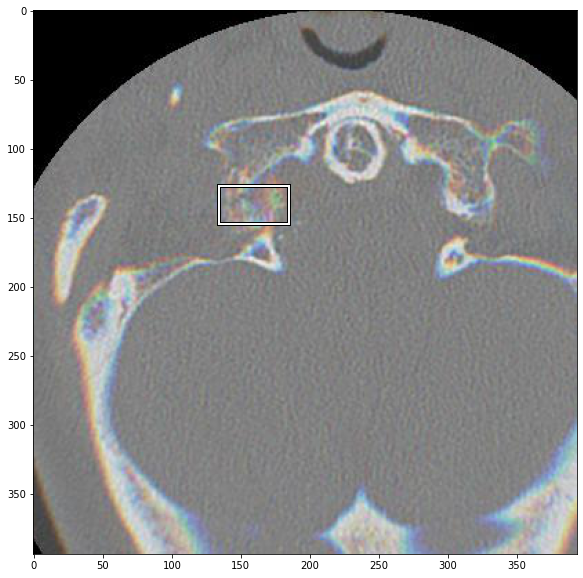

In [16]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = pos_df.loc['1.2.826.0.1.3680043.16643.43']
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{int(s.Slice)}.jpeg'))
bbox = list(s[['new_x', 'new_y','width','height']])
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
show_image(image, bbox)

## Dataset

In [17]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, mask_dir, pos_df, neg_df):
        self.image_dir = images_dir_path
        self.mask_dir = mask_dir
        self.pos_df = pos_df
        self.neg_df = neg_df

    def __len__(self) -> int:
        return len(self.pos_df) * 2

    def __getitem__(self, idx):
        
        is_pos = (idx % 2) == 0
        
        if is_pos:
            s = self.pos_df.iloc[idx // 2]
        else:
            rand_idx = np.random.randint(0, len(self.neg_df))
            s = self.neg_df.iloc[rand_idx]
        UID = s.StudyInstanceUID
        # print(s)
        axial_index = int(s.Slice)
        img = Image.open(os.path.join(self.image_dir, UID, f"{axial_index}.jpeg"))
        
        mask = Image.open(os.path.join(self.mask_dir, UID, f'{axial_index}.png'))
        mask = mask.crop((s.xmin/2, s.ymin/2, s.xmax/2, s.ymax/2))
        
        if pd.isna(s.x):
            pascal_bboxes = []
            class_labels = []
        else:
            pascal_bboxes = [[s.new_x, s.new_y, s.new_x + s.width, s.new_y + s.height]]
            class_labels = np.ones(1)

        return img, pascal_bboxes, class_labels, idx

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, MASK_DIR, pos_df, neg_df)
da[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=394x394 at 0x7F934027A280>,
 [[176.20042081675894,
   216.71419000000003,
   193.50482081675892,
   237.09936000000002]],
 array([1.]),
 0)

## Transform

{'bboxes': tensor([[261.5273, 244.6128, 326.2891, 282.2230]]), 'labels': tensor([1.], dtype=torch.float64), 'image_id': tensor([10]), 'img_size': (512, 512), 'img_scale': tensor([1.])}
torch.Size([3, 512, 512])
tensor(-1.) tensor(0.8508)


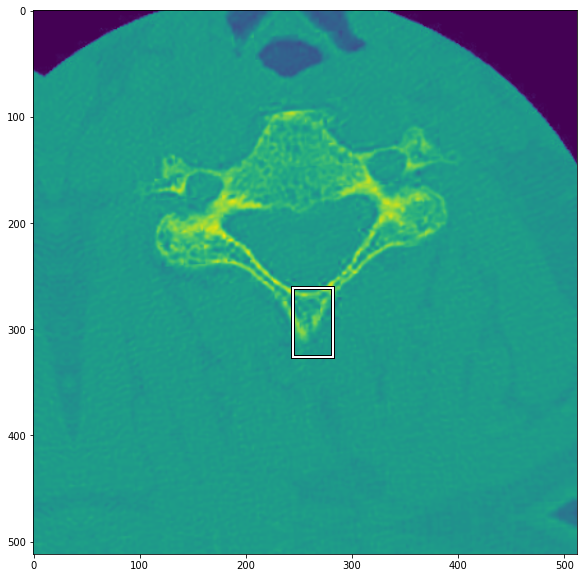

In [18]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.ShiftScaleRotate(p=0.5, rotate_limit=15),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )



class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=None
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id
        ) = self.ds[index]

        if len(pascal_bboxes) > 0:
            # image, pascal_bboxes = crop_image(image, pascal_bboxes[0], crop_box)
            pascal_bboxes = pascal_bboxes[0]
            pascal_bboxes[0] = max(0, pascal_bboxes[0])
            pascal_bboxes[1] = max(0, pascal_bboxes[1])
            pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
            pascal_bboxes[3] = min(image.height, pascal_bboxes[3])
            
            sample = {
                "image": np.array(image, dtype=np.float32),
                "bboxes": [pascal_bboxes],
                "labels": class_labels,
            }
            sample = self.transforms(**sample)
            sample["bboxes"] = np.array(sample["bboxes"])
            image = sample["image"]
            labels = sample["labels"]

            # print(sample)

            _, new_h, new_w = image.shape
            if len(sample["bboxes"]) > 0:
                sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                                :, [1, 0, 3, 2]
                                                ]  # convert to yxyx

                target = {
                    "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
                    "labels": torch.as_tensor(labels),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
            else:
                target = {
                    "bboxes": torch.zeros((0, 4)),
                    "labels": torch.tensor([]),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
        else:
            # image = image.crop(crop_box)   
            image = self.transforms(image=np.array(image, dtype=np.float32), bboxes=[], labels=[])["image"]
            _, new_h, new_w = image.shape
            target = {
                "bboxes": torch.zeros((0, 4)),
                "labels": torch.tensor([]),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        
        

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms(IMAGE_SIZE))
img, ann, idx = train_dataset[10]
print(ann)
print(img.shape)
print(img.min(), img.max())
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[2, :, :])

if len(ann['bboxes']) > 0:
    draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [19]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [20]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [21]:
# from effdet.config.model_config import efficientdet_model_param_dict
# list(efficientdet_model_param_dict.keys())

In [22]:


def get_det_model(image_size, checkpoint=None):
    if checkpoint is None:

        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        model = model.to(device)
        return model
    else:
        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint), map_location=torch.device(device))
        model.load_state_dict(state["model"])
        model = model.to(device)
        return model

model = get_det_model(IMAGE_SIZE, checkpoint)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

26374778


In [23]:
# class_out, box_out = model.model(img.unsqueeze(0).to(device))
# anchors = Anchors.from_config(model.model.config).to(device)
# decode_model_outputs(class_out, box_out, anchors, model.model.config.num_levels)

In [24]:
# val_model = DetBenchPredict(model.model).to(device)
# val_model(img.unsqueeze(0).to(device))

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [26]:
from evaluate import *
# evaluator = Evaluate(model.model, save_dir=os.path.join(DATA_DIR, 'predictions', wandb.run.name))

# evaluator.evaluate(59)

## Train one epoch

In [27]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step(e + i / epoch_iteration)

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })
            
        
#         if (i + e * epoch_iteration) % 100 == 0:
#             # val_model = DetBenchPredict(model.model).to(device)
#             val_model.eval()
#             val_index = (e * epoch_iteration + i) // 100
#             prediction = evaluate(e, val_model, val_index=val_index)
            
#             model.train()

    return np.mean(loss_list)

In [28]:
# val_UIDs = list(val_df.index.unique())
# len(val_UIDs)

In [29]:
class ValidationDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, mask_path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.mask_path = mask_path
        self.transforms = transforms

        self.len = len(self.df)

    def __getitem__(self, i):

        try:
            s = self.df.iloc[i]
            UID = s.name
            img = Image.open(os.path.join(self.path, UID, f'{int(s.Slice)}.jpeg'))

            mask = Image.open(os.path.join(self.mask_path, UID, f'{int(s.Slice)}.png'))
            
            if self.transforms is not None:
                img, mask = self.transforms(img, mask)
        except Exception as ex:
            print(ex)
            return None, None

        return img, s.pixel_spacing, s.Slice == s.Start, s[['xmin','ymin','xmax','ymax']].values, mask

    def __len__(self):
        return self.len

class ValidationTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.image_size = image_size

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(0.5, 0.5),
        ])
        
        self.mask_transform = T.Compose([
            T.ToTensor(),
        ])

    def forward(self, x, mask):
        x = self.transform(x)
        mask = self.mask_transform(mask)
        return x, mask
    
# val_tf = ValidationTransform(IMAGE_SIZE)

# UID = '1.2.826.0.1.3680043.10001'
# evaluate_df = val_df.loc[UID].sort_values('Slice')
# # evaluate_df.iloc[0]
# # print(evaluate_df)
# val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR, transforms=val_tf)
# # val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

# # iter_d = iter(val_loader)
# # next(iter_d)
# # next(iter_d)
# # next(iter_d)
# img, pixel_spacing, is_end, bbox, mask = val_ds[138]
# print(img.shape, bbox.shape, mask.shape)
# print(mask.min(), mask.max())
# print(bbox)
# _, axs = plt.subplots(1, 2)
# axs[0].imshow(img[0, :, :])
# axs[1].imshow(mask[0, :, :])

In [30]:
def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

In [31]:
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)

In [32]:
# val_df.loc['1.2.826.0.1.3680043.10001'].sort_values('Slice')

In [33]:


def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
    croped_list = []
    for i in range(imgs_tensor.shape[0]):
        xmin, ymin, xmax, ymax = boundary_list[i, :]
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        # print(xmin, ymin, xmax, ymax)
        croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
        croped = TF.resize(croped, (img_size, img_size))
        croped_list.append(croped)
        
    return torch.stack(croped_list, 0)

def predict_det(x, model):
    
    bboxes = model(x) # N x 1 x 6
    
    return bboxes[:, 0, :]

def get_original_bbox(bbox, boundary):
    scale = 512. / (boundary[:, [2]] - boundary[:, [0]])
    
    org_bbox = bbox / scale
    org_bbox[:, 0] += boundary[:, 0]
    org_bbox[:, 1] += boundary[:, 1]
    org_bbox[:, 2] += boundary[:, 0]
    org_bbox[:, 3] += boundary[:, 1]
    
    return org_bbox

def get_class_score(scores, class_list, eps=1e-2):
    result = scores.new_zeros((scores.shape[0], 8)) + eps
    class_list = torch.nan_to_num(class_list).long()
    result[torch.arange(scores.shape[0]), class_list] = scores
    
    return result

def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()


# table_columns=['UID', 'loss', 'Predictions','Labels']
# evaluate_table = wandb.Table(data=[], columns=table_columns)

def log_prediction(UID, prediction):
    # log
    
    
    label = label_df.loc[UID].values
    loss = cal_loss(prediction, label)
   
    # my_data = [UID, loss, prediction, label]
    
    # evaluate_table.add_data(*my_data)
    
    wandb.run.log({
        # 'evaluate_table' : evaluate_table
        'eval_sample_UID' : int(UID.split('.')[-1]),
        'eval_sample_loss' : loss,
    })
    


def evaluate(e, det_model, UID=None, val_index=None):
    
    if UID is None:
        UID = val_UIDs[val_index]
    
    with torch.no_grad():
        evaluate_df = val_df.loc[UID].sort_values('Slice')
        # print(evaluate_df)
        val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR,val_tf)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

        predictions = []
        x0 = val_ds[0][0]
        x1 = val_ds[1][0]
        x0, x1 = x0.to(device), x1.to(device)
        prev2 = torch.stack((x0, x1))

        for x, pixel_spacings, is_starts, axial_boundary, seg_result in val_loader:
            x = x.to(device)
            

            # (N+2), 1, 512, 512
            x = torch.cat((prev2, x), dim=0)

            r = x[:-2, :, :, :]
            g = x[1:-1, :, :, :]
            b = x[2:, :, :, :]

            start_indices = torch.argwhere(is_starts)
            r[start_indices, :, :, :] = b[start_indices, :, :, :]
            g[start_indices, :, :, :] = b[start_indices, :, :, :]

            prev2 = b[-2:, :, :, :]

            x = torch.cat((r, g, b), dim=1)

            batch_probs = x.new_zeros((x.shape[0], 8)) + 1e-2

            seg_result = seg_result.to(device)
            # seg_areas = seg_result.count_nonzero(dim=[1, 2, 3]) / (256 * 256)

            # active_indices = torch.argwhere(seg_areas > 0.001)
            active_indices = seg_result.nonzero()[:, 0].unique()

            if active_indices.numel() == 0:
                predictions.append(batch_probs.cpu())
                continue

            axial_boundary, seg_result = axial_boundary.to(device), seg_result.to(device)
            active_indices = active_indices.reshape(-1)

            if active_indices.numel() != batch_size:
                x = x[active_indices, :, :, :]
                seg_result = seg_result[active_indices, :, :, :]
                pixel_spacings = pixel_spacings[active_indices]
                axial_boundary = axial_boundary[active_indices]
                


            # axial_boundary = get_axial_boundary(seg_result, pixel_spacings, seg_img_size=256)  # N x 4, 512 scale

            x = crop_resize_images(x, axial_boundary) # N x 3 x 512 x 512 croped


            # for det_model in det_models:
            det_result = predict_det(x, det_model)
            bboxes, scores = get_original_bbox(det_result[:, :4], axial_boundary), det_result[:, 4]
            class_list = get_bbox_class_list(seg_result[:, 0, :, :], bboxes / 2)
            probs = get_class_score(scores, class_list) # N x 7

            batch_probs[active_indices, :] = probs
            # print(probs)
            predictions.append(batch_probs.cpu())

        predictions = torch.concat(predictions)
      
        # predictions[:, 0] = torch.amax(predictions, dim=1)
        prediction = predictions.amax(dim=0)
        prediction[0] = prediction[1:].amax()
        # print(predictions)
        # return predictions
        
        
        if wandb.run is not None:
            log_prediction(UID, prediction.numpy())
        
        
        return prediction

# val_model = DetBenchPredict(model.model).to(device)
# val_model = val_model.eval()
# prediction = evaluate(0, val_model)
# prediction

In [34]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))


In [35]:
epoch = 0


In [36]:
from evaluate import *
evaluator = Evaluate(model.model, save_dir=os.path.join(DATA_DIR, 'predictions', wandb.run.name))

In [37]:
# start_batch_index = 0
# for i in range(252):
#     loss, pos_loss, neg_loss, batch_index = evaluator.evaluate(epoch + i + start_batch_index)
#     wandb.log({
#         'val/total_loss': loss,
#         'val/pos_loss': pos_loss,
#         'val/neg_loss': neg_loss,
#         'val/batch_index' : batch_index
#     })

In [ ]:
for e in range(100):

    train_loss = train_one_epoch(epoch, model, train_loader)

    epoch += 1    
    scheduler.step()
    
    with torch.no_grad():
        loss, pos_loss, neg_loss, batch_index = evaluator.evaluate(epoch)
        wandb.log({
            'val/total_loss': loss,
            'val/pos_loss': pos_loss,
            'val/neg_loss': neg_loss,
            'val/batch_index' : batch_index
        })
        save_state(epoch)
        
    
        
    # if epoch % 10 == 0:
    #     save_state(epoch)

t 0 loss 0.0855 c 0.0657 b 0.0004: 100%|██████████| 456/456 [06:34<00:00,  1.16it/s]


test df length :  2429


100%|██████████| 152/152 [00:26<00:00,  5.84it/s]


loss :0.4100589480260014 pos_loss:0.1687447744219841 neg_loss:0.3886813423254919


t 1 loss 0.1712 c 0.1083 b 0.0013: 100%|██████████| 456/456 [06:17<00:00,  1.21it/s]


test df length :  3430


100%|██████████| 215/215 [00:35<00:00,  6.04it/s]


loss :0.4237596732133054 pos_loss:0.3061826882268436 neg_loss:0.32353132504355553


t 2 loss 0.1322 c 0.0926 b 0.0008: 100%|██████████| 456/456 [06:17<00:00,  1.21it/s]


test df length :  2621


100%|██████████| 164/164 [00:27<00:00,  5.91it/s]


loss :0.4660459263072749 pos_loss:0.17038867044740896 neg_loss:0.44051807100231266


t 3 loss 0.1030 c 0.0800 b 0.0005: 100%|██████████| 456/456 [06:19<00:00,  1.20it/s]


test df length :  2048


100%|██████████| 128/128 [00:22<00:00,  5.64it/s]


loss :0.3796748936713296 pos_loss:0.12465728207835104 neg_loss:0.7307987263056661


t 4 loss 0.0987 c 0.0720 b 0.0005: 100%|██████████| 456/456 [06:15<00:00,  1.21it/s]


test df length :  2473


100%|██████████| 155/155 [00:26<00:00,  5.92it/s]


loss :0.17458341516971088 pos_loss:0.027267028930544553 neg_loss:0.22429314583515736


t 5 loss 0.0745 c 0.0601 b 0.0003: 100%|██████████| 456/456 [06:17<00:00,  1.21it/s]


test df length :  3029


100%|██████████| 190/190 [00:32<00:00,  5.82it/s]


loss :0.29313838343205134 pos_loss:0.12049177892729161 neg_loss:0.5473461097637248


t 6 loss 0.1390 c 0.1099 b 0.0006: 100%|██████████| 456/456 [06:18<00:00,  1.21it/s]


test df length :  3187


100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


loss :0.3938487605479025 pos_loss:0.0005278764874344457 neg_loss:0.4678595934596173


t 7 loss 0.0967 c 0.0722 b 0.0005: 100%|██████████| 456/456 [06:17<00:00,  1.21it/s]


test df length :  2721


100%|██████████| 171/171 [00:32<00:00,  5.26it/s]


loss :0.2369416625912721 pos_loss:0.18763816791081994 neg_loss:0.34581567825080006


t 8 loss 0.0569 c 0.0452 b 0.0002: 100%|██████████| 456/456 [06:16<00:00,  1.21it/s]


test df length :  2526


100%|██████████| 158/158 [00:27<00:00,  5.69it/s]


loss :0.6393562280079068 pos_loss:0.16073080259005518 neg_loss:0.5857839351186127


t 9 loss 0.0686 c 0.0561 b 0.0002: 100%|██████████| 456/456 [06:18<00:00,  1.21it/s]


test df length :  3001


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


loss :0.36727832162658436 pos_loss:0.31524262690817745 neg_loss:0.2069817823336546


t 10 loss 0.0887 c 0.0654 b 0.0005:  27%|██▋       | 124/456 [01:44<04:32,  1.22it/s]

In [ ]:
save_state(epoch)